# CRAFT fine-tuning and inference interactive demo

This example notebook shows how to fine-tune a pretrained CRAFT conversational model for the task of forecasting conversational derailment, as shown in the "Trouble on the Horizon" paper (note however that due to nondeterminism in the training process, the results will not exactly reproduce the ones shown in the paper; if you need the exact inference results from the paper, see our [online demo](https://colab.research.google.com/drive/1GvICZN0VwZQSWw3pJaEVY-EQGoO-L5lH) that does inference only using the saved already-fine-tuned model from the paper).

Also note that this notebook is written primarily for the Wikipedia data. It will still work on the Reddit CMV data as well, but be aware that if seeking to compare results to those in the paper, the actual Reddit CMV evaluation contains some nuances that are not present in the Wikipedia data, as detailed in the [CMV version of the online demo](https://colab.research.google.com/drive/1aGBUBeiF3jT-GtBU9SDUoxhsjwKZaMKl?usp=sharing).

In [1]:
# Set before importing pytorch: https://discuss.pytorch.org/t/cuda-visible-device-is-of-no-use/10018/12.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# import necessary libraries, including convokit
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import random
import unicodedata
import itertools
from convokit import download, Corpus
from tqdm import tqdm
from sklearn.metrics import roc_curve

from datasets import Dataset, DatasetDict
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer
)
import evaluate

# from config import *

%matplotlib inline

/Volumes/Users/tran_s2/.local/lib/python3.11/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(
2024-05-04 23:32:15.116982: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 23:32:15.118334: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 23:32:15.143093: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild Tenso

## Part 1: set up data preprocessing utilities

We begin by setting up some helper functions for preprocessing the ConvoKit Utterance data for use with CRAFT.

In [3]:
corpus_name = 'wikiconv'
label_metadata = "conversation_has_personal_attack" if corpus_name == "wikiconv" else "has_removed_comment"
# Name of the utterance metadata field that contains comment-level toxicity labels, if any. Note
# that CRAFT does not strictly need such labels, but some datasets like the wikiconv data do include
# it. For custom datasets it is fine to leave this as None.
utt_label_metadata = "comment_has_personal_attack" if corpus_name == "wikiconv" else None
my_random_seed = 1

In [4]:
# Given a ConvoKit conversation, preprocess each utterance's text by tokenizing and truncating.
# Returns the processed dialog entry where text has been replaced with a list of
# tokens, each no longer than MAX_LENGTH - 1 (to leave space for the EOS token)
def processDialog(dialog):
    processed = []
    for utterance in dialog.iter_utterances():
        # skip the section header, which does not contain conversational content
        if corpus_name == 'wikiconv' and utterance.meta['is_section_header']:
            continue
        processed.append({"text": utterance.text, "is_attack": int(utterance.meta[utt_label_metadata]) if utt_label_metadata is not None else 0, "id": utterance.id})
    if utt_label_metadata is None:
        # if the dataset does not come with utterance-level labels, we assume that (as in the case of CMV)
        # the only labels are conversation-level and that the actual toxic comment was not included in the
        # data. In that case, we must add a dummy comment containing no actual text, to get CRAFT to run on 
        # the context preceding the dummy (that is, the full prefix before the removed comment)
        processed.append({"text": "", "is_attack": int(dialog.meta[label_metadata]), "id": processed[-1]["id"] + "_dummyreply"})
    return processed

# Load context-reply pairs from the Corpus, optionally filtering to only conversations
# from the specified split (train, val, or test).
# Each conversation, which has N comments (not including the section header) will
# get converted into N-1 comment-reply pairs, one pair for each reply 
# (the first comment does not reply to anything).
# Each comment-reply pair is a tuple consisting of the conversational context
# (that is, all comments prior to the reply), the reply itself, the label (that
# is, whether the reply contained a derailment event), and the comment ID of the
# last comment in the context (for later use in re-joining with the ConvoKit corpus).
# The function returns a list of such pairs.
def corpus2dataset(corpus, split=None, last_only=False, shuffle=False):
    dataset_dict = {
        "context": [],
        "id": [],
        "labels": []
    }
    for convo in corpus.iter_conversations():
        # consider only conversations in the specified split of the data
        if split is None or convo.meta['split'] == split:
            dialog = processDialog(convo)
            iter_range = range(1, len(dialog)) if not last_only else [len(dialog)-1]
            for idx in iter_range:
                label = dialog[idx]["is_attack"]
                # when re-joining with the corpus we want to store forecasts in
                # the last comment of each context (i.e. the comment directly
                # preceding the reply), so we must save that comment ID.
                comment_id = dialog[idx-1]["id"]
                # gather as context all utterances preceding the reply
                context = [u["text"] for u in dialog[:idx]]
                dataset_dict["context"].append(context)
                dataset_dict["id"].append(comment_id)
                dataset_dict["labels"].append(label)
    if shuffle:
        return Dataset.from_dict(dataset_dict).shuffle(seed=2024)
    else:
        return Dataset.from_dict(dataset_dict)

## Part 2: load the data

Now we load the labeled corpus (Wikiconv or Reddit CMV) from ConvoKit, and run some transformations to prepare it for use with PyTorch

In [5]:
if corpus_name == "wikiconv":
    corpus = Corpus(filename=download("conversations-gone-awry-corpus"))
elif corpus_name == "cmv":
    corpus = Corpus(filename=download("conversations-gone-awry-cmv-corpus"))

Dataset already exists at /Volumes/Users/tran_s2/.convokit/downloads/conversations-gone-awry-corpus


In [6]:
# let's check some quick stats to verify that the corpus loaded correctly
print(len(corpus.get_utterance_ids()))
print(len(corpus.get_speaker_ids()))
print(len(corpus.get_conversation_ids()))

30021
8069
4188


In [7]:
# Let's also take a look at some example data to see what kinds of information/metadata are available to us
print(list(corpus.iter_conversations())[0].__dict__)
print(list(corpus.iter_utterances())[0])

{'obj_type': 'conversation', '_owner': <convokit.model.corpus.Corpus object at 0x7fa1ac28b790>, '_id': '146743638.12652.12652', 'vectors': [], '_meta': ConvoKitMeta({'page_title': 'User talk:2005', 'page_id': 1003212, 'pair_id': '143890867.11926.11926', 'conversation_has_personal_attack': False, 'verified': True, 'pair_verified': True, 'annotation_year': '2018', 'split': 'train'}), '_utterance_ids': ['146743638.12652.12652', '146743638.12667.12652', '146842219.12874.12874', '146860774.13072.13072'], '_speaker_ids': None, 'tree': None}
Utterance(id: '146743638.12652.12652', conversation_id: 146743638.12652.12652, reply-to: None, speaker: Speaker(id: 'Sirex98', vectors: [], meta: ConvoKitMeta({})), timestamp: 1185295934.0, text: '== [WIKI_LINK: WP:COMMONNAME] ==\n', vectors: [], meta: ConvoKitMeta({'is_section_header': True, 'comment_has_personal_attack': False, 'toxicity': 0, 'parsed': [{'rt': 3, 'toks': [{'tok': '=', 'tag': 'NFP', 'dep': 'punct', 'up': 3, 'dn': []}, {'tok': '=', 'tag':

In [8]:
# load the corpus into PyTorch-formatted train, val, and test datasets
dataset = DatasetDict({
    "train": corpus2dataset(corpus, "train", last_only=True, shuffle=True), 
    "val": corpus2dataset(corpus, "val", last_only=True),
    "val_for_tuning": corpus2dataset(corpus, "val"),
    "test": corpus2dataset(corpus, "test")
})

In [9]:
# check data sizes
dataset

DatasetDict({
    train: Dataset({
        features: ['context', 'id', 'labels'],
        num_rows: 2508
    })
    val: Dataset({
        features: ['context', 'id', 'labels'],
        num_rows: 840
    })
    val_for_tuning: Dataset({
        features: ['context', 'id', 'labels'],
        num_rows: 4399
    })
    test: Dataset({
        features: ['context', 'id', 'labels'],
        num_rows: 4365
    })
})

In [10]:
# check examples to verify that processing happened correctly
for i in range(5):
    print(len(dataset["train"][i]["context"]))
    print(dataset["train"][i]["context"])

7
["http://www.politico.com/blogs/bensmith/0910/Two_wars.html\nAgreed. Above is another article from September 2010 where Obama says that the U.S. is still fighting two wars. Thus, since many govt. officials say that the Iraq War isn't over yet, it shouldn't be considered over in this article either.", "Well there's obviously a war ongoing in Iraq, with more than two thousand casualties anually, and the UN's criteria for a major war is at least one thousand deaths annually. But I think this article should do more to differentiate the three different phases of the war. The war against Saddam's Iraq, the civil war with US occupation and the civil war without US occupation. The ongoing conflict seems to fit the last phase (or is starting to). It would solve how most of this article is far too big too. ", 'With 50,000 U.S. troops, tens of thousands more private military forces, and thousands of  casualties annually, it\'s obvious that the war is still going on. Unfortunately some are still

In [11]:
def find_max_len(tokens_list):
    index = 0
    for i, tokens in enumerate(tokens_list):
        if len(tokens) > len(tokens_list[index]):
            index = i
    return index
def tokenize_context(context, tokenizer, max_len=512):
    tokenized_context = []
    for utterance in context:
        tokenized_context.append(tokenizer.encode(utterance, add_special_tokens=False))
    def truncate_context(tokenized_context, max_len):
        if sum([len(utterance) for utterance in tokenized_context])\
           + len(tokenized_context) + 1 < max_len:
            final_context = [tokenizer.cls_token_id]
            for utterance in tokenized_context:
                final_context += utterance + [tokenizer.sep_token_id]
            
            padding = [tokenizer.pad_token_id] * (max_len - len(final_context))
            mask = [1 for _ in range(len(final_context))] + [0 for _ in range(len(padding))]
            input_ids = torch.tensor(final_context + padding)
            mask = torch.tensor(mask)
            return {"input_ids": input_ids, "attention_mask": mask}
        
        while sum([len(utterance) for utterance in tokenized_context])\
              + len(tokenized_context) + 1 > max_len:
            truncate_idx = find_max_len(tokenized_context)
            tokenized_context[truncate_idx] = tokenized_context[truncate_idx][1:]
        final_context = [tokenizer.cls_token_id]
        for utterance in tokenized_context:
            final_context += utterance + [tokenizer.sep_token_id]
            input_ids = torch.tensor(final_context)
            mask = torch.tensor([1 for _ in range(len(final_context))])
        return {"input_ids": input_ids, "attention_mask": mask}
    return truncate_context(tokenized_context, max_len)

In [12]:
# tokenize the dataset so it is usable by huggingface
# shamelessly stolen from https://github.com/CornellNLP/calm (thanks tushaar)

tokenizer = AutoTokenizer.from_pretrained(
    "google-bert/bert-base-cased", model_max_length=512, truncation_side="left", padding_side="right"
)

tokenizer_helper = lambda inst: tokenize_context(inst["context"], tokenizer)
# tokenizer.encode_plus(
#     text=f" {tokenizer.sep_token} ".join(inst["context"]), 
#     add_special_tokens=True,
#     padding="max_length",
#     truncation=True,
#     max_length=512,
# )
tokenized_dataset = dataset.map(tokenizer_helper, remove_columns=["context"], num_proc=20)

Map (num_proc=20):   0%|          | 0/2508 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1094 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (858 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (762 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (659 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Map (num_proc=20):   0%|          | 0/840 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (812 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (744 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Map (num_proc=20):   0%|          | 0/4399 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (812 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (575 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (867 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Map (num_proc=20):   0%|          | 0/4365 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (686 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (592 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (783 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (790 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1206 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

In [13]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 2508
    })
    val: Dataset({
        features: ['id', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 840
    })
    val_for_tuning: Dataset({
        features: ['id', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 4399
    })
    test: Dataset({
        features: ['id', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 4365
    })
})

In [14]:
print(tokenizer.decode(tokenized_dataset["train"][2]['input_ids']))

[CLS] or unwilling change. This is the proper change. Meanwhile Ryu Please dont Revert me to simply add the same thing back Revert to make an edit Or cuss and get overreact. You keep saying " that I added " when you give the reason for adding back. I also remind you that Its not my page as you seem to thank. [SEP]ūtsū Kakusei Forumu " then " Forme " can be used, and even then it's not necessary to refer to " Awakened Forme " as " an alternate Forme " because that's just bad English due to the fact that Game Freak decided to go with the French word instead of the English word. — [SEP] of a deal. It is his Awakened Forme and it doesnt matter. Why are you making such a big deal. You dont know everything. It doesnt bother me if its not there, it will when the games come out. I dont know why it " giv ( es ) ( you ) aggravation ". [SEP] it gets called something with " Forme " in the name then we can say " This is Mewtwo's X Forme " but not say that " This is an alternate Forme ". Also, stop 

In [15]:
# Check to see if everything looks alright.
print(
    f"CONVO={tokenizer.decode(tokenized_dataset['train'][0]['input_ids'])}"
    f"\n\nLABEL={tokenized_dataset['train'][0]['labels']}"
)

CONVO=[CLS] http : / / www. politico. com / blogs / bensmith / 0910 / Two _ wars. html Agreed. Above is another article from September 2010 where Obama says that the U. S. is still fighting two wars. Thus, since many govt. officials say that the Iraq War isn't over yet, it shouldn't be considered over in this article either. [SEP] in Iraq, with more than two thousand casualties anually, and the UN's criteria for a major war is at least one thousand deaths annually. But I think this article should do more to differentiate the three different phases of the war. The war against Saddam's Iraq, the civil war with US occupation and the civil war without US occupation. The ongoing conflict seems to fit the last phase ( or is starting to ). It would solve how most of this article is far too big too. [SEP]ing the Iraq War Is Over'''military officials quietly concede that the " Iraq War is over " spin is just that : spin.'''The fact is, the Iraq war continues'''http : / / www. huffingtonpost. co

In [16]:
tokenized_dataset.set_format("torch")

## Part 3: define the inference pipeline

CRAFT inference consists of three steps: (1) using the utterance encoder to produce embeddings of each comment in the context (2) running the comment embeddings through the context encoder to get a final representation of conversational context (3) running the classifier head on the context embedding. To streamline the subsequent code, we encapsulate these three steps in a single PyTorch `nn.Module`.

## Part 4: define training loop

Now that we have all the model components defined, we need to define the actual training procedure. This will be a fairly standard neural network training loop, iterating over batches of labeled dialogs and computing cross-entropy loss on the predicted label. We will also define evaluation functions so that we can compute accuracy on the validation set after every epoch, allowing us to keep the model with the best validation performance. Note that for the sake of simpler code, validation accuracy is computed in the "unfair" manner using a single run of CRAFT over the full context preceding the actual personal attack, rather than the more realistic (and complicated) iterated evaluation that is used for final evaluation of the test set (in practice the two metrics track each other fairly well, making this a reasonable simplification for the sake of easy validation).

## Part 5: define the evaluation procedure

We're almost ready to run! The last component we need is some code to evaluate performance on the test set after fine-tuning is completed. This evaluation should use the full iterative procedure described in the paper, replicating how a system might be deployed in practice, without knowledge of where the personal attack occurs

In [17]:
@torch.inference_mode
@torch.no_grad
def evaluateDataset(dataset, finetuned_model, device, threshold=0.5, temperature=1.0):
    finetuned_model = finetuned_model.to(device)
    convo_ids = []
    preds = []
    scores = []
    for data in tqdm(dataset):
        input_ids = data['input_ids'].to(device, dtype = torch.long).reshape([1,-1])
        attention_mask = data['attention_mask'].to(device, dtype = torch.long).reshape([1,-1])
        outputs = finetuned_model(input_ids=input_ids, attention_mask=attention_mask)
        probs = F.softmax(outputs.logits / temperature, dim=-1)
        convo_ids.append(data["id"])
        raw_score = probs[0,1].item()
        preds.append(int(raw_score > threshold))
        scores.append(raw_score)
    return pd.DataFrame({"prediction": preds, "score": scores}, index=convo_ids)

## Part 6: build and fine-tune the model

We finally have all the components we need! Now we can instantiate the CRAFT model components, load the pre-trained weights, and run fine-tuning.

In [18]:
config = AutoConfig.from_pretrained("google-bert/bert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=2)
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [19]:
def compute_metrics(eval_pred):
    cls_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return cls_metrics.compute(predictions=predictions, references=labels)

In [20]:
training_args = TrainingArguments(
    output_dir=f"{corpus_name}",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=6.7e-6,  # https://arxiv.org/pdf/2110.05111.pdf
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    prediction_loss_only=False,
    run_name=f"bertcraft_{corpus_name}",
    logging_steps=1,
    seed=4300,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.738300,0.663279,0.613095,0.619883,0.609195,0.630952
2,0.756700,0.646501,0.652381,0.671171,0.636752,0.709524
3,1.067900,0.733907,0.623810,0.557423,0.676871,0.473810
4,1.066900,0.709729,0.646429,0.652632,0.641379,0.664286
5,0.169800,0.736669,0.646429,0.632880,0.658098,0.609524


TrainOutput(global_step=1570, training_loss=0.5559660266918741, metrics={'train_runtime': 443.0336, 'train_samples_per_second': 28.305, 'train_steps_per_second': 3.544, 'total_flos': 3299412634214400.0, 'train_loss': 0.5559660266918741, 'epoch': 5.0})

## Part 6.5: Threshold tuning

For CRAFT, we selected the decision threshold by iterating over possible thresholds on the validation set and picking the one that gives the highest validation accuracy. Since the optimal threshold may be different for BERT, we replicate this process with our trained BERT forecaster.

In [20]:
config = AutoConfig.from_pretrained("google-bert/bert-base-cased")

if corpus_name == 'wikiconv':
    checkpoint = "628"  # ep0: 79, ep1: 158, ep3: 237
elif corpus_name == 'cmv':
    checkpoint = "2056"  # ep0: 129, ep1: 258, ep3: 387
# for custom data, specify your own checkpoint!
finetuned_model = AutoModelForSequenceClassification.from_pretrained(
    f"{corpus_name}/checkpoint-{checkpoint}"
)

In [21]:
val_scores = evaluateDataset(tokenized_dataset["val_for_tuning"], finetuned_model, "cuda")

100%|██████████| 4399/4399 [00:45<00:00, 96.82it/s]


In [22]:
val_scores

,prediction,score
51451175.46452.46444,1,0.744203
51451323.46486.46486,1,0.728309
44473697.13344.13334,1,0.715480
44474698.13311.13580,1,0.741384
44474912.13327.13327,1,0.754954
...,...,...
162936818.6494.6494,0,0.196492
162940314.6722.6722,0,0.396881
162941948.8249.8217,0,0.481498
162944257.8619.8619,1,0.593046


In [23]:
# for each CONVERSATION, whether or not it triggers will be effectively determined by what the highest score it ever got was
highest_convo_scores = {c.id: -1 for c in corpus.iter_conversations(lambda convo: convo.meta['split']=="val")}
for utt_id in val_scores.index:
    parent_convo = corpus.get_utterance(utt_id).get_conversation()
    utt_score = val_scores.loc[utt_id].score
    if utt_score > highest_convo_scores[parent_convo.id]:
        highest_convo_scores[parent_convo.id] = utt_score

In [24]:
val_convo_ids = [c.id for c in corpus.iter_conversations(lambda convo: convo.meta['split'] == 'val')]
val_labels = np.asarray([int(corpus.get_conversation(c).meta[label_metadata]) for c in val_convo_ids])
val_scores = np.asarray([highest_convo_scores[c] for c in val_convo_ids])

In [25]:
# use scikit learn to find candidate threshold cutoffs
_, _, thresholds = roc_curve(val_labels, val_scores)

In [26]:
def acc_with_threshold(y_true, y_score, thresh):
    y_pred = (y_score > thresh).astype(int)
    return (y_pred == y_true).mean()
def f1_with_threshold(y_true, y_score, thresh):
    y_pred = (y_score > thresh).astype(int)
    tp = ((y_pred == 1) & (y_true == 1)).sum()
    fp = ((y_pred == 1) & (y_true == 0)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()
    return 2 * tp / (2 * tp + fp + fn)

accs = [acc_with_threshold(val_labels, val_scores, t) for t in thresholds]
best_acc_idx = np.argmax(accs)
print("Best threshold is", thresholds[best_acc_idx], "with accuracy", accs[best_acc_idx])

f1s = [f1_with_threshold(val_labels, val_scores, t) for t in thresholds]
best_f1_idx = np.argmax(f1s)
print("Best threshold is", thresholds[best_f1_idx], "with f1", f1s[best_f1_idx])

overall = [accs[i] + f1s[i] for i in range(len(accs))]
best_overall_idx = np.argmax(overall)
print("Best threshold is", thresholds[best_overall_idx], "with overall", accs[best_overall_idx], f1s[best_overall_idx])
best_threshold = thresholds[best_acc_idx]

Best threshold is 0.5194612145423889 with accuracy 0.6476190476190476
Best threshold is 0.46917158365249634 with f1 0.6938369781312127
Best threshold is 0.5136609077453613 with overall 0.6476190476190476 0.6851063829787234


## Part 7: run test set evaluation

Now that we have successfully fine-tuned the model, we run it on the test set so that we can evaluate performance.

In [27]:
forecasts_df = evaluateDataset(tokenized_dataset["test"], finetuned_model, "cuda", threshold=best_threshold)

100%|██████████| 4365/4365 [00:45<00:00, 95.89it/s]


In [28]:
forecasts_df.head()

,prediction,score
240149353.16340.16332,0,0.371858
240153963.16690.16690,0,0.267274
241131342.18781.18523,1,0.554032
241132175.18826.18826,1,0.723076
463673734.2170.2155,0,0.365914


## Part 8: merge predictions back into corpus and evaluate

Now that the hard part is done, all that is left to do is to evaluate the predictions. Since the predictions are in no particular order, we will first merge each prediction back into the source corpus, and then evaluate each conversation according to the order of utterances within that conversation.

In [29]:
# We will add a metadata entry to each test-set utterance signifying whether, at the time
# that CRAFT saw the context *up to and including* that utterance, CRAFT forecasted the
# conversation would derail. Note that in datasets where the actual toxic comment is
# included (such as wikiconv), we explicitly do not show that comment to CRAFT (since
# that would be cheating!), so that comment will not have an associated forecast.
for convo in corpus.iter_conversations():
    # only consider test set conversations (we did not make predictions for the other ones)
    if convo.meta['split'] == "test":
        for utt in convo.iter_utterances():
            if utt.id in forecasts_df.index:
                utt.meta['forecast_score'] = forecasts_df.loc[utt.id].score

In [30]:
# Finally, we can use the forecast-annotated corpus to compute the forecast accuracy.
# Though we have an individual forecast per utterance, ground truth is at the conversation level:
# either a conversation derails or it does not. Thus, forecast accuracy is computed as follows:
#   - True positives are cases that actually derail, for which the model made at least one positive forecast ANYTIME prior to derailment
#   - False positives are cases that don't derail but for which the model made at least one positive forecast
#   - False negatives are cases that derail but for which the model made no positive forecasts prior to derailment
#   - True negatives are cases that don't derail, for which the model made no positive forecasts
# Note that in the included datasets (wikiconv and cmv), by construction, all forecasts we obtained are forecasts made prior to derailment
# (since these datasets end right before or right at the toxic comment). This simplifies  the computation of forecast metrics as we now 
# do not need to explicitly consider when a forecast was made. But if you are using a custom dataset where conversations continue past
# the toxic comment, you will need to take that into account when evaluating.
best_threshold = thresholds[best_acc_idx]
print(best_threshold)
conversational_forecasts_df = {
    "convo_id": [],
    "label": [],
    "score": [],
    "prediction": []
}

for convo in corpus.iter_conversations():
    if convo.meta['split'] == "test":
        conversational_forecasts_df['convo_id'].append(convo.id)
        conversational_forecasts_df['label'].append(int(convo.meta[label_metadata]))
        forecast_scores = [utt.meta['forecast_score'] for utt in convo.iter_utterances() if 'forecast_score' in utt.meta]
        conversational_forecasts_df['score'] = np.max(forecast_scores)
        conversational_forecasts_df['prediction'].append(int(np.max(forecast_scores) > best_threshold))

conversational_forecasts_df = pd.DataFrame(conversational_forecasts_df).set_index("convo_id")
print("Accuracy = ", (conversational_forecasts_df.label == conversational_forecasts_df.prediction).mean())

0.5194612145423889
Accuracy =  0.65


In [31]:
# in addition to accuracy, we can also consider applying other metrics at the conversation level, such as precision/recall
def get_pr_stats(preds, labels):
    tp = ((labels==1)&(preds==1)).sum()
    fp = ((labels==0)&(preds==1)).sum()
    tn = ((labels==0)&(preds==0)).sum()
    fn = ((labels==1)&(preds==0)).sum()
    print("Precision = {0:.4f}, recall = {1:.4f}".format(tp / (tp + fp), tp / (tp + fn)))
    print("False positive rate =", fp / (fp + tn))
    print("F1 =", 2 / (((tp + fp) / tp) + ((tp + fn) / tp)))

get_pr_stats(conversational_forecasts_df.prediction, conversational_forecasts_df.label)

Precision = 0.6221, recall = 0.7643
False positive rate = 0.4642857142857143
F1 = 0.6858974358974359


## Part 9: model analysis: how early is early warning?

The goal of CRAFT is to forecast outcomes in advance, but how far in advance does it typically make its prediction? Following the paper, we measure this in two ways: the number of *comments* between the first prediction and the actual derailment, and how much *elapsed time* that gap actually translates to.

In [32]:
comments_until_derail = {} # store the "number of comments until derailment" metric for each conversation
time_until_derail = {} # store the "time until derailment" metric for each conversation

for convo in corpus.iter_conversations():
    if convo.meta['split'] == "test" and convo.meta[label_metadata]:
        # filter out the section header as usual
        utts = [utt for utt in convo.iter_utterances() if not (corpus_name == 'wikiconv' and utt.meta['is_section_header'])]
        if utt_label_metadata is not None:
            # if utterances have individual toxicity labels, we assume that the last comment in the conversation
            # is the one that is toxic (as in the case for wikiconv)
            derail_idx = len(utts) - 1
        else:
            # otherwise, we assume that the toxic comment is not included and that derailment happens immediately
            # after the last comment in the conversation
            derail_idx = len(utts)
        # now scan the utterances in order until we find the first derailment prediction (if any)
        for idx in range(1, len(utts)):
            try:
                if utts[idx].meta['forecast_score'] > best_threshold:
                    comments_until_derail[convo.id] = derail_idx - idx
                    #time_until_derail[convo.id] = utts[derail_idx].timestamp - utts[idx].timestamp
                    break
            except:
                continue

In [33]:
# compute some quick statistics about the distribution of the "number of comments until derailment" metric
comments_until_derail_vals = np.asarray(list(comments_until_derail.values()))
print(np.min(comments_until_derail_vals), np.max(comments_until_derail_vals), np.median(comments_until_derail_vals), np.mean(comments_until_derail_vals))

1 14 3.0 3.356687898089172


In [34]:
# compute some quick statistics about the distribution of the "time until derailment" metric
# note that since timestamps are in seconds, we convert to hours by dividing by 3600, to make it more human readable
#time_until_derail_vals = np.asarray(list(time_until_derail.values())) / 3600
#print(np.min(time_until_derail_vals), np.max(time_until_derail_vals), np.median(time_until_derail_vals), np.mean(time_until_derail_vals))

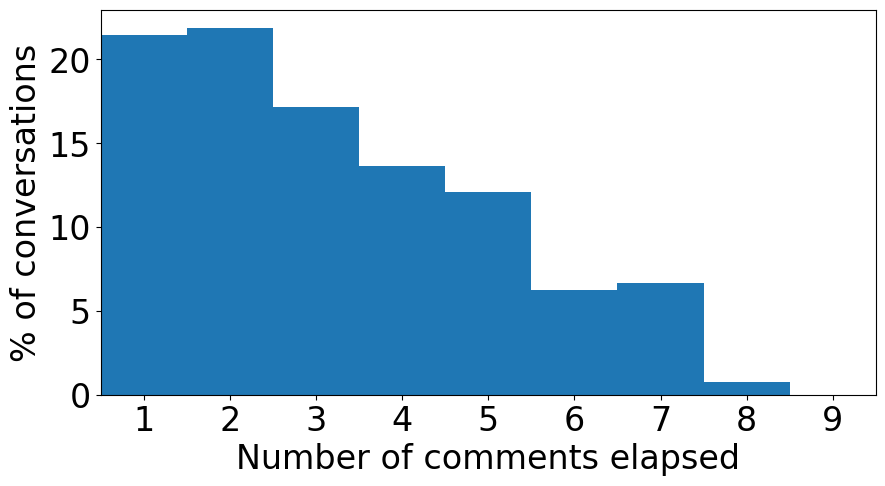

In [36]:
# visualize the distribution of "number of comments until derailment" as a histogram (reproducing Figure 4 from the paper)
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['font.size'] = 24
plt.hist(comments_until_derail_vals, bins=range(1, np.max(comments_until_derail_vals)), density=True)
plt.xlim(1,10)
plt.xticks(np.arange(1,10)+0.5, np.arange(1,10))
plt.yticks(np.arange(0,0.25,0.05), np.arange(0,25,5))
plt.xlabel("Number of comments elapsed")
plt.ylabel("% of conversations")
plt.show()